# Capstone Project
## Paul Reiners

* * *

## Definition
### Project Overview
My project is my code for the [Kaggle Shelter Animal Outcomes contest](https://www.kaggle.com/c/shelter-animal-outcomes).  As described on Kaggle:
>Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year.

### Problem Statement
As described on Kaggle:
>Using a dataset of intake information including breed, color, sex, and age from the 
> [Austin Animal Center](http://www.austintexas.gov/department/animal-services), 
> we're asking Kagglers to predict the outcome for each animal.

The possible outcomes and sub-outcomes are:
* Adoption
 - Foster
 - Offsite
 - Barn
* Died
 - In Kennel
 - In Foster
 - Enroute
 - At Vet
 - In Surgery
* Euthanasia
 - Suffering
 - Aggressive
 - Behavior
 - Rabies Risk
 - Medical
 - Court/Investigation
* Return_to_owner
* Transfer
 - Partner
 - SCRP
 - Barn

This is a classification problem.  The contestant needs to estimate, for each animal in the test set, the likelihood of each outcome (sub-outcomes are not predicted).

### Metrics
As described on Kaggle:
> <p>Submissions are evaluated using the <a href="https://www.kaggle.com/wiki/MultiClassLogLoss">multi-class logarithmic loss</a>. Each incident has been labeled with one true class. For each animal, you must submit a set of predicted probabilities (one for every class). The formula is then,</p>
> <p>$$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),$$</p>
> <p>where N is the number of animals in the test set, M is the number of outcomes, \\(log\\) is the natural logarithm, \\(y_{ij}\\) is 1 if observation \\(i\\) is in outcome \\(j\\) and 0 otherwise, and $p_{ij}$ is the predicted probability that observation \\(i\\) belongs to outcome \\(j\\).</p>
> <p>The submitted probabilities for a given animal are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with \\(max(min(p,1-10^{-15}),10^{-15})\\).</p>


## Analysis
### Data Exploration
Let's import the training data and see what the first few rows look like:

In [13]:
%matplotlib inline
import pandas as pd 

train_data = pd.read_csv('../data/train.csv', parse_dates=['DateTime'])
train_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


Let's see how much missing data there is for the training set:

In [2]:
train_data.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

And for the test set:

In [3]:
test_data = pd.read_csv('../data/test.csv', parse_dates=['DateTime'])
test_data.isnull().sum()

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

We can see that many of the animals have missing names.  This should not matter since it is unlikely that an animal's outcome would depend on its name.  (However, we will find out later that whether the animal *is* named has an effect on its outcome.)  The many missing *OutcomeSubtype* values should also not matter since we are only trying to predict the *OutcomeType*.  Finally, there is only one missing value for *SexuponOutcome* and 24 missing values for *AgeuponOutcome*.  

### Exploratory Visualization
Let's look at a plot of the counts of different outcomes.

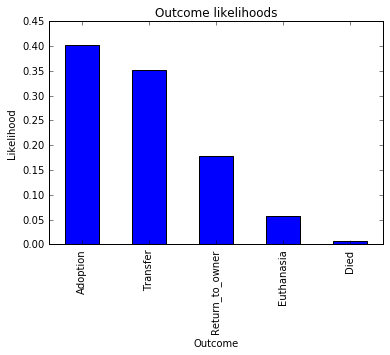

In [4]:
import numpy as np
import matplotlib.pyplot as plt

value_counts = train_data['OutcomeType'].value_counts(normalize=True)
value_counts.plot(kind='bar')
plt.xlabel("Outcome")
plt.ylabel("Likelihood")
plt.title("Outcome likelihoods")

It turns out that about 40% of animals are adopted.  The "Transfer" outcome doesn't really seem like an outcome to me, but perhaps we can assume that 40% of the transferred animals are also later adopted.

For each outcome, let's look at the distribution of outcome subtypes (except for *Return_to_owner*, which has no subtypes).

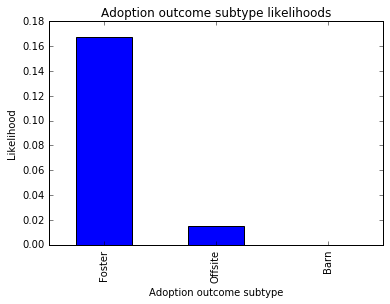

In [5]:
def show_outcome_subtype_counts(outcome_type):
    data = train_data.loc[train_data['OutcomeType'] == outcome_type]
    value_counts = data['OutcomeSubtype'].value_counts(normalize=True)
    value_counts.plot(kind='bar')
    plt.xlabel(outcome_type + " outcome subtype")
    plt.ylabel("Likelihood")
    plt.title(outcome_type + " outcome subtype likelihoods")
    
show_outcome_subtype_counts('Adoption')

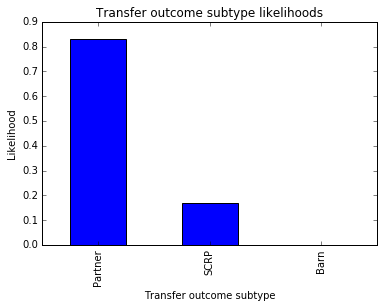

In [6]:
show_outcome_subtype_counts('Transfer')

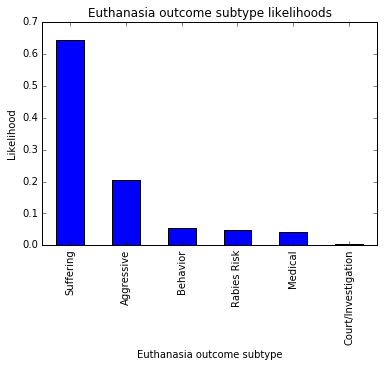

In [7]:
show_outcome_subtype_counts('Euthanasia')

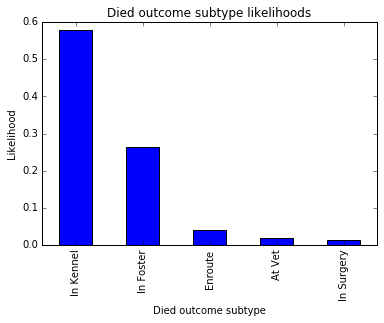

In [8]:
show_outcome_subtype_counts('Died')

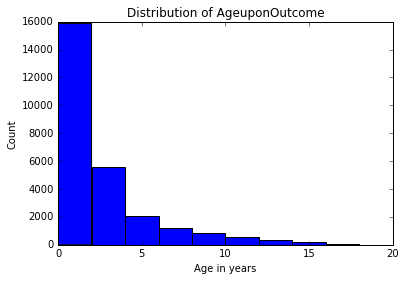

In [9]:
from core.preprocessing.feature_extraction_scaling import preprocess_age
import numpy

train_data['AgeuponOutcome'] = train_data['AgeuponOutcome'].apply(preprocess_age)
days = train_data['AgeuponOutcome'].dropna().values
years = days / 365
plt.hist(years)
plt.xlabel("Age in years")
plt.ylabel("Count")
plt.title("Distribution of AgeuponOutcome")
plt.show()

I was interested in checking whether the [black dog syndrome](https://en.wikipedia.org/wiki/Black_dog_syndrome) held in this data set.

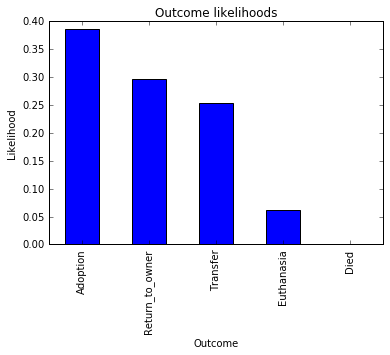

In [10]:
dog = train_data['AnimalType'] == "Dog"
black = train_data['Color'] == "Black"
black_dogs = train_data[black & dog]
black_dogs['OutcomeType'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel("Outcome")
plt.ylabel("Likelihood")
plt.title("Outcome likelihoods")

It doesn't appear to hold. All animals have an adoption rate of about 0.40, while, for black dogs, the rate is slightly less than 0.40.  It is interesting, though, that the rate of black dogs returned to their owners is much higher than the rate in the general population.  So, in a certain sense, perhaps there is something to the syndrome.

### Algorithms and Techniques
I used a wide variety of classification algorithms.  I got this list of algorithms from [Classifier comparison](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).  Here is the log-loss performance of the algorithms:

<table>
  <caption>Log-loss performance</caption>
  <tr>
    <th>Algorithm</th>
    <th>Cat</th> 
    <th>Dog</th>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.57658</td> 
    <td>0.95536</td>
  </tr>
  <tr>
    <td>XGBoost</td>
    <td>0.59622</td> 
    <td>0.97434</td>
  </tr>
  <tr>
    <td>Nearest Neighbors</td>
    <td>1.66271</td> 
    <td>1.29723</td>
  </tr>
  <tr>
    <td>Decision Tree</td>
    <td>0.76244</td> 
    <td>1.16388</td>
  </tr>
  <tr>
    <td>AdaBoost</td>
    <td>1.52599</td> 
    <td>1.56269</td>
  </tr>
  <tr>
    <td>Naive Bayes</td>
    <td>1.95993</td> 
    <td>2.32285</td>
  </tr>
  <tr>
    <td>Linear Discriminant Analysis</td>
    <td>0.71434</td> 
    <td>1.00974</td>
  </tr>
  <tr>
    <td>Quadratic Discriminant Analysis</td>
    <td>1.78311</td> 
    <td>2.30627</td>
  </tr>
  <tr>
    <td>Linear SVM</td>
    <td>0.74214</td> 
    <td>1.02569</td>
  </tr>
  <tr>
    <td>RBF SVM</td>
    <td>0.67900</td> 
    <td>1.01030</td>
  </tr>
</table>

The code for generating these scores is in [`scripts.classifier_comparison`](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/blob/master/src/scripts/classifier_comparison.py).  As you can see, random forests performed best at classifying both cats and dogs, but XGBoost was close behind.

### Benchmark
The benchmark was provided by the Kaggle contest.  It is the score obtained when predicting that all animals in the test set are adopted.
![benchmark](https://raw.githubusercontent.com/paul-reiners/kaggle-shelter-animal-outcomes/master/img/benchmark.tiff?token=ABcpq_lnHcFWJawl5E6X5rVMl4AeRaNzks5XNME4wA%3D%3D "Benchmark")

## Methodology
### Data Preprocessing
First of all, note that we use scaling between 0.0 and 1.0 for all the features.  Most of our features are categorical and the scaling is a byproduct of the one-hot encoding we use on categorical features.  This leaves only the *AgeuponOutcome* feature.  We scale this using an `sklearn.preprocessing.MinMaxScaler`.  This scaling is essential for the SVMs and nearest neighbors algorithms to run effectively.

#### Name field
Is it possible that the name of an animal can affect its outcome?  It seems unlikely given that a new owner can always rename his new pet.  But could it matter whether the name is cute, unusual, or in some other way remarkable?  Do dogs named "Fido" or "Buster" have different outcomes from those named "Mister Puddinplop" or "Slurpy"?  It's hard to see how to automate the calculation of the cuteness of a name.  It is however easy to calculate the popularity of a name.  So I created a feature called *NamePopularity*.  This feature did have some predictive power but not enough to move me up the leader-board.

However it turned out that whether the animal *was* named did matter.  Animals that were not named were most likely to be transferred, while animals that were named were most likely to be adopted.  Thus I added a feature called *IsNamed* and dropped the *Name* feature.

#### DateTime field
I split this into three fields:
* Month
* Day of week
* Hour of day

This came in handy since I was able to create new predictive features such as *IsWeekend* and *IsSpring*.  Further, the outcome did depend on the hour of day.

#### SexuponOutcome field
This is an overloaded field that I broke up into two new features:
* *Sex*
* *IsIntact* (the complement of 'is spayed/neutered')

There was only one missing value and that was in the training set, so I simply dropped that row.

#### AgeuponOutcome field
For the training set, I simply dropped the rows with missing values.
I then converted all of the values to days and scaled it using `sklearn.preprocessing.MinMaxScaler`.
For the test set, I used the mean age for missing values. I tried logarithmic scaling on the age variable, but leaving it as it was worked better.

#### Breed field
This is a categorical variable.  I used one-hot encoding to break this up into numeric features.  In particular, I used the `get_dummies` method implemented in pandas.

For cats, I pretty much left this field alone, although I did create the following features:
* *Domestic Longhair*
* *Domestic Shorthair*

For dogs, the breed field was more useful.  First I created features for 
[dog breed groups](http://www.akc.org/dog-breeds/groups/):
* *Sporting Group*
* *Toy Group* 
* *Herding Group* 
* *Hound Group*
* *Non-Sporting Group* 
* *Terrier Group* 
* *Working Group*

Finally, I created these new dog features:
* *IsPitBull*
* [*IsDangerous*](https://lifestyle9.org/top-10-most-dangerous-dog-breeds-that-you-should-stay-away-from/)
* [*IsDoodleDog*](http://patch.com/massachusetts/holliston-hopkinton/what-is-a-doodle-dog)

Being a pit bull or some other dangerous breed of dog had a significant effect on the dog's outcome.  (I was slightly disappointed to find that being a "doodle dog" did not seem to have any effect good or bad.)

#### Color field
This is also a categorical field which I used one-hot encoding on.  For both dogs and cats, I created an *IsBlack* feature.

My data preprocessing code can be found in 
[core.preprocessing.feature_extraction_scaling](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/blob/master/src/core/preprocessing/feature_extraction_scaling.py)

#### Feature selection
To select the features to be used in my models, I used a combination of data exploration, intuition, and, later in the process, `sklearn.feature_selection.SelectKBest`.  I found the following features to be the best in predicting outcomes:

* Cats and dogs both
 - *AgeuponOutcome*
 - *IsWeekend*
 - *IsEightAM*
 - *IsNineAM*
 - *IsTenAM*
 - *IsFivePM*
 - *IsSixPM*
 - *IsNamed*
 - *IsIntact*
* Cats only
 - *IsSpring*
* Dogs only
 - *IsDangerous*
 
My feature selection code is in [`scripts.select_features`](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/blob/master/src/scripts/select_features.py).

### Implementation
There were several steps in my process of creating a Kaggle submission:
1. [Select features.](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/blob/master/src/scripts/select_features.py)
2. [Compare classifiers to select best model types.](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/blob/master/src/scripts/classifier_comparison.py)
3. Optimize parameters for models.  (See `find_best_params` method implementations in [core.learning.classifiers](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/tree/master/src/core/learning/classifiers) classes.)
4. [Test the optimized models on the training data.](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/blob/master/src/scripts/create_submission.py)  
5. If the models work better than my best submission so far, run the models on the test data and submit the results.

In order to know whether my models had improved without possibly wasting a Kaggle submission, I tested them with a [log-loss method I implemented](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/blob/master/src/core/learning/performance_metrics.py).

### Refinement
The table below shows how I refined my submissions over time.  The percent field indicates the 'top percent' my submission is in.  For example, 35 means that my submission was in the top 35% on the leader board:

    Best scores:
        Date        Type                       MyLLScore  KaggleLLScore  Percent  Submission Tag
        ========================================================================================
        04/27/2016  BaseLinePredictor          20.61577        20.25113           Submission00
        04/27/2016  NearestNeighborsPredictor  14.37823        13.94696           Submission01
        04/27/2016  NearestNeighborsPredictor   5.07153         5.20698           Submission02
        04/28/2016  NearestNeighborsPredictor   3.70919         3.59477       81  Submission03
        04/28/2016  NearestNeighborsPredictor   1.00052         1.00036       66  Submission04
        04/28/2016  DecisionTreePredictor       0.94061         0.90950       59  Submission05
        04/29/2016  DecisionTreePredictor       0.92471         0.90939       58  Submission06
        04/29/2016  RandomForestPredictor       0.88390         0.86738       50  Submission07
        04/29/2016  RandomForestPredictor       0.85608         0.84534       47  Submission08
        04/29/2016  RandomForestPredictor       0.82221         0.84454       46  Submission09
        05/03/2016  RandomForestPredictor       0.81721         0.81486       40  Submission10
        05/04/2016  RandomForestPredictor       0.79887         0.79934       35  Submission11
        05/04/2016  RandomForestPredictor       0.79229         0.79204       34  Submission12
        05/04/2016  RandomForestPredictor       0.79955         0.79167       35  Submission13

    Submission05: Started using DecisionTreeClassifier(max_depth=6).
    Submission06: Broke down SexuponOutcome into IsIntact and IsMale.
    Submission07: Started using SelectKBest.
    Submission08: Started using GridSearchCV on RandomForestPredictor.
    Submission09: Set n_estimators on RandomForestClassifier.
    Submission10: Started using hour of the day as a feature.
    Submission11: Added IsFivePM and IsSixPM features.
    Submission12: Added IsThreePM feature.
    Submission13: Retrain on *all* the training data.

(Unfortunately, I didn't record how I improved things on my first four submissions.)

## Results
### Model Evaluation and Validation
Random forest models (separate ones for cats and dogs) worked best (although I am also going to try XGBoost next) and that is what I ultimately ended up using.  For my random forest implementation, I used `sklearn.ensemble.RandomForestClassifier` with the following parameters:

* Cat: {'n_estimators': 160, 'criterion': 'gini', 'max_depth': 10}
* Dog: {'n_estimators': 160, 'criterion': 'gini', 'max_depth': 7}

To find the best values for these parameters, I used `sklearn.grid_search.GridSearchCV`.

My random forest code can be found in 
[`core.learning.classifiers.random_forest_predictor`](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/blob/master/src/core/learning/classifiers/random_forest_predictor.py).

In summary, my end-to-end process was:

1. Explore the data to find new features to exploit.
1. Find a good selection of features both new and old.
2. Find which classification algorithm worked best on that selection of features.
3. Optimize the parameters of that algorithm.
4. Train the algorithm and test it.
5. Repeat the process.

On the training data of my best model so far, the log-loss value is 0.79955.  On the Kaggle test data, the log-loss value is 0.79167.  Since the latter value is less than the former, no over-fitting occurred.

Here is my current position on the [leader board](https://www.kaggle.com/c/shelter-animal-outcomes/leaderboard):

![position](https://raw.githubusercontent.com/paul-reiners/kaggle-shelter-animal-outcomes/master/img/my-position.tiff?token=ABcpq4S8HIsUilamlRKAr995IUqhg6y3ks5XNQTOwA%3D%3D)

### Justification
My log-loss value of 0.79167 beats the benchmark value of 20.25113 by a factor of about 26.  This is a significant improvement.  However there are teams on the [leader board](https://www.kaggle.com/c/shelter-animal-outcomes/leaderboard) that have done better.  At the time of writing, the leader has a log-loss score of 0.45175.  Now it's possible that some of the higher entries on the leader board are over-fitting, but it's impossible to know.

I can't say for certain that I've actually solved this problem.  However I am pleased with the fact that the significant features I found "make sense".  For example, it's intuitively clear that people probably do tend to adopt more kittens in the spring.

One problem with this competition, in my opinion, is the *DateTime* field.  It is possible to make predictions on the outcome based on the date and time of the outcome.  *However, this is an after-the-fact prediction and does not give any insight into the eventual outcome of an animal.*  For example, adoptions tend to occur on weekends and the evenings, but that doesn't give you any predictive ability regarding an animal's fate ahead of time.  I would say that this is data leakage and a major flaw in the contest.  Another contestant, 
[Gerard Toonstra](https://www.kaggle.com/remap1), mentioned this in a 
[forum post](https://www.kaggle.com/c/shelter-animal-outcomes/forums/t/19867/datetime-question/116366#post116366).

> I'm pretty positive that using datetime in predictions is not valid and it's actually the source of data leakage in two ways. Transfers can be reliably predicted this way, because apparently they happen when multiple animals leave 
at exactly the same time. The second weaker leak is that the test data is simply a random extract from the same data. This means that the model can learn things and events that were specific for a given day (no euth done that day, no transfers, above usual adoptions, etc).

> Without exploiting this leak, I got 0.720 from a single xgb model. With the leak as a feature, I got to #3 on the LB.

## Conclusion
### Free-Form Visualization
The primary factor affecting the outcome of an animal is its age.  Let's see how the various outcomes change depending on age.

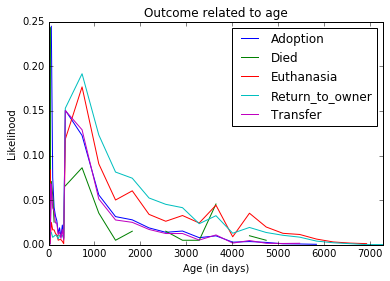

In [11]:
outcome_type_dict = {}
for outcome_type in train_data['OutcomeType'].unique():
    group = train_data.loc[train_data['OutcomeType'] == outcome_type]
    counts = group['AgeuponOutcome'].value_counts(normalize=True).sort_index()
    outcome_type_dict[outcome_type] = counts

outcomes_df = pd.DataFrame(outcome_type_dict)
outcomes_df.plot(kind='line')
plt.xlabel("Age (in days)")
plt.ylabel("Likelihood")
plt.title("Outcome related to age")

From the plot we can see that the most common outcome is to be returned to owner up to the age of about 8 years (3000 days).  After the age of 8 years, though, the most common outcome is unfortunately euthanasia.

Let's use a logarithmic scale for the age:

(0.0, 0.4)

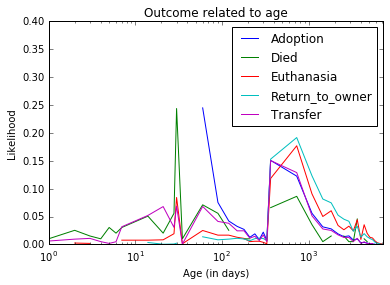

In [12]:
outcomes_df.plot(kind='line', logx=True,linestyle='-')
plt.xlabel("Age (in days)")
plt.ylabel("Likelihood")
plt.title("Outcome related to age")
plt.legend(loc='best')
plt.ylim(ymax=0.40)

Notice the spikes in adoptions and deaths.  Here we can see that the most likely outcome for young animals is adoption.  Very young animals have a most likely outcome of death.  I'm guessing that this is not the fault of the shelters, but a result of young, neglected animals being left at the shelter. 

### Reflection
I learned some interesting things from this analysis.  The outcome of cats is seasonal, while the outcome of dogs is basically not seasonal.  It looks like people adopt kittens during the spring-time and around Christmas.  On the other hand, the outcome of dogs is much more dependent on their breed than it is for cats.  This is mainly because of the danger of some breeds of dogs.

Another very interesting finding is that it is easier to predict the outcome of cats than it is dogs.  As mentioned earlier, using random forests for both cats and dogs, the log-loss is 0.57658 for cats and 0.95536 for dogs.  This is despite the fact that I spent more time looking for good predictive dog features than I did for cat features.  I have an hypothesis about this, but no actual data to back it up.  Obviously the behavior and temperament of an animal at the shelter will have a significant effect on the animal's outcome.  And I believe that there is more variability of the behavior of dogs in shelters than in cats.  Further this behavior variability is not captured in the data.  To give an example, a dog might run up to you in the shelter, making it more likely that you would adopt him or her (this actually happened to me).  However, good luck in getting a strange cat to run up to you.  Anyway, this is my hypothesis&mdash;I don't insist on it.  Take it or leave it.  It would be interesting to do more data gathering and research on this question.

### Improvement
While I was nearing the end of this project, I started reading an interesting, informative book, 
[*Python Machine Learning*](https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning)
by [Sebastian Raschka](http://sebastianraschka.com).  I found some ideas in there that I would have liked to implement but didn't have time for.  In particular, I would have liked to have stream-lined my workflow with Pipelines.  There was no reason why I should have to run three or four scripts in succession to come up with results.  This could have all been automated with one script.

Trying to climb a Kaggle leader board is quite addictive (very addictive, actually) and can turn into a game of diminishing returns (if I can only decrease my log-loss by 0.00014, I'll move up another slot on the leader board!).  Nevertheless, the Kaggle contest still has two months to go and I plan on continuing to improve my solution during that time.

* * *

This project is dedicated to my dogs Edmund and Sophie who both had an *OutcomeType* of *Adoption* from the [Golden Valley Humane Society](https://www.animalhumanesociety.org).

![Edmund and Sophie](https://raw.githubusercontent.com/paul-reiners/kaggle-shelter-animal-outcomes/master/img/SophieEdmund.jpg?token=ABcpq-9BQ6DDbidsHh0Jfl6F2Bw_-PrLks5XNTBSwA%3D%3D "Optional title")